RFE NEE

Running RFE analysis...
RFE analysis complete.


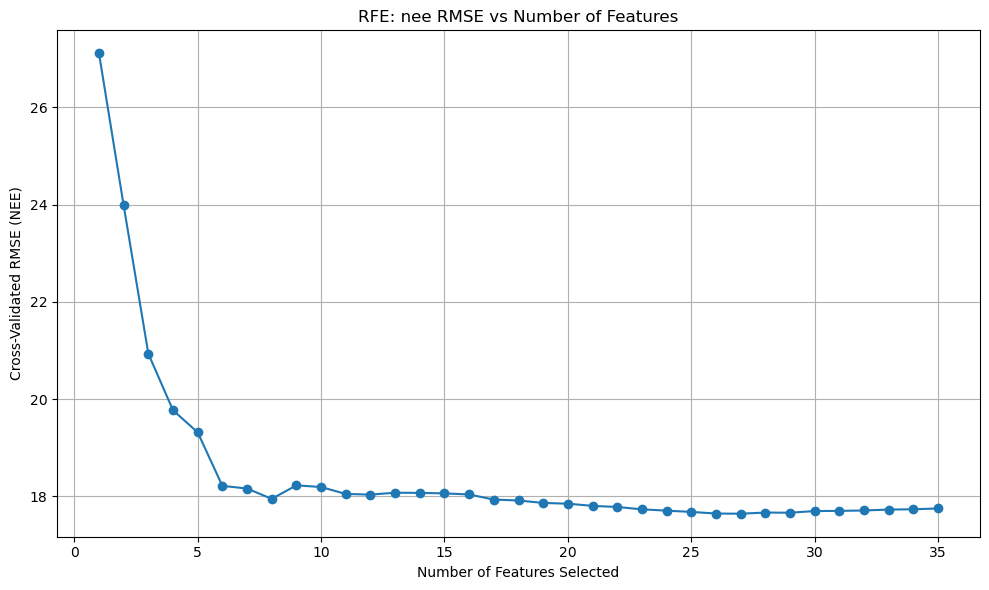

RFE curve plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/nee/rfe.png

--- RFE Results ---
Optimal number of features found by RFE: 27
Features selected by RFE: ['EVI', 'NDVI', 'sur_refl_b01', 'NDWI', 'srad', 'tmean_C', 'vap', 'vs', 'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm', 'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT', 'land_cover', 'month', 'lai', 'fpar', 'Percent_Tree_Cover', 'sm_surface', 'snow_cover', 'snow_depth']
-------------------

Training full model to determine top 6 predictors...
Model training complete.


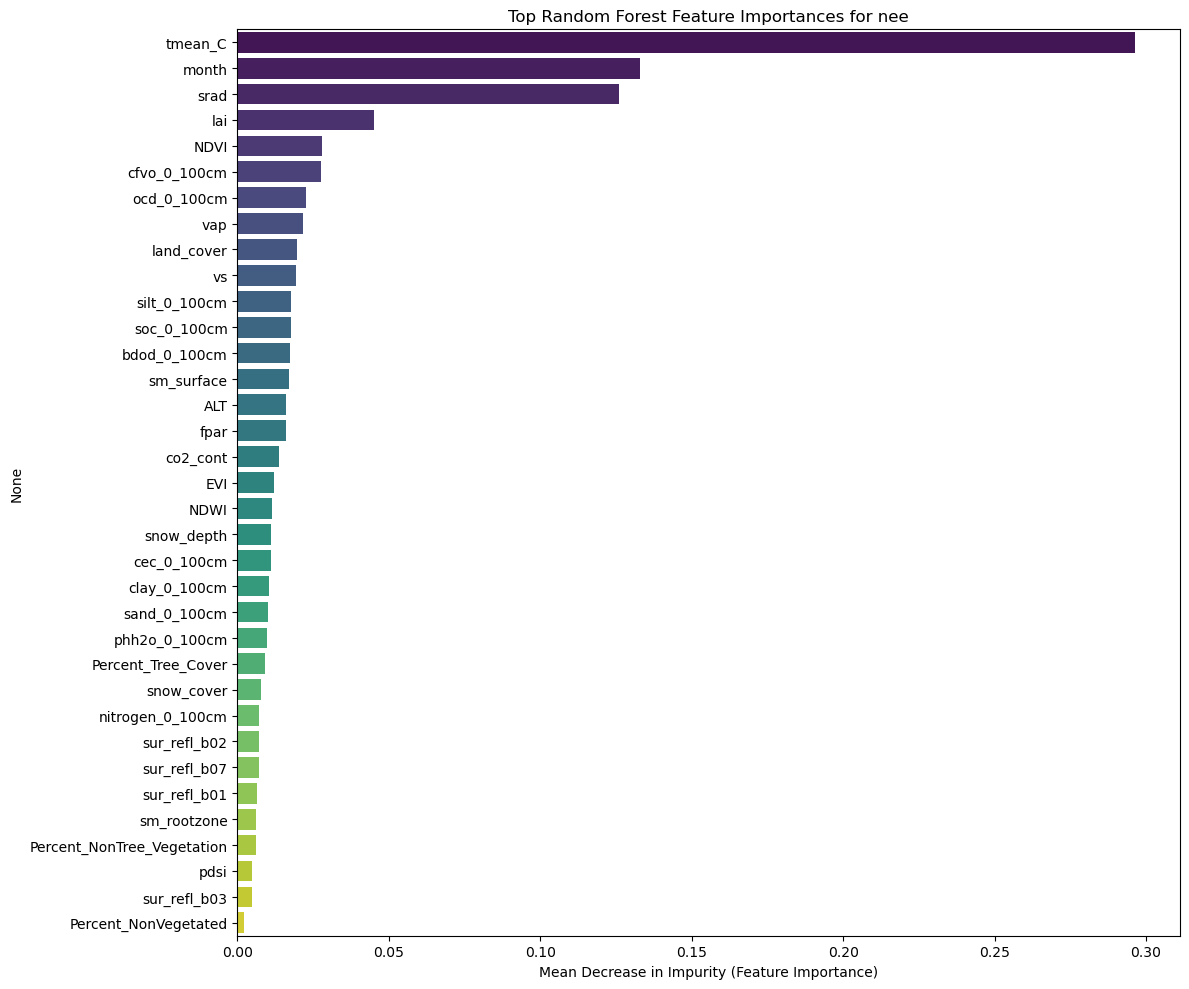

Feature importance plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/nee/rf_importance.png

--- TopPredictor Selection ---
Top predictors selected: ['tmean_C', 'month', 'srad', 'lai', 'NDVI', 'cfvo_0_100cm', 'ocd_0_100cm', 'vap', 'land_cover']
---------------------------------

New training dataframe with top 6 predictors saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/nee/training_data_nee_top_preds.csv
Shape of the new dataframe: (3430, 10)
Columns in the new dataframe: ['tmean_C', 'month', 'srad', 'lai', 'NDVI', 'cfvo_0_100cm', 'ocd_0_100cm', 'vap', 'land_cover', 'nee']


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, root_mean_squared_error
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Load your dataset
df = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv")
df = df[df['flux_method'] == 'EC']

# 2. Create tmean_C and date
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# 3. Define predictors and target
predictor_vars = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month', 
    'lai', 'fpar', 'Percent_NonTree_Vegetation',
    'Percent_NonVegetated', 'Percent_Tree_Cover', 'sm_surface', 'sm_rootzone',
    'snow_cover',
    'snow_depth'#, 'NDSI_snow_cover'
]

target_var = 'nee'

out_path = os.path.join("/explore/nobackup/people/spotter5/anna_v/v2/loocv", target_var)
os.makedirs(out_path, exist_ok = True)

# 4. Drop rows with missing predictor or target values
df_model = df[predictor_vars + [target_var]].dropna()

# 5. Prepare input data
X = df_model[predictor_vars]
y = df_model[target_var]

# --- RFE Analysis Section ---
print("Running RFE analysis...")
# 6. Set up scoring, model, and cross-validation for RFE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rf_rfe = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7. Run RFECV
rfecv = RFECV(estimator=rf_rfe, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)
print("RFE analysis complete.")

# 8. Plot RMSE vs number of features from RFE
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    # Negate the score to plot positive RMSE values
    -rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (NEE)")
plt.title(f"RFE: {target_var} RMSE vs Number of Features")
plt.grid(True)
plt.tight_layout()
# --- Save plot with the original filename ---
rfe_plot_path = os.path.join(out_path, 'rfe.png')
plt.savefig(rfe_plot_path)
plt.show()
print(f"RFE curve plot saved to: {rfe_plot_path}")

# 9. Print features selected by RFE (for informational purposes)
rfe_selected_features = list(X.columns[rfecv.support_])
print("\n--- RFE Results ---")
print("Optimal number of features found by RFE:", rfecv.n_features_)
print("Features selected by RFE:", rfe_selected_features)
print("-------------------\n")


# --- Top 6 Predictor Selection Section ---
print("Training full model to determine top 6 predictors...")
# 10. Train a Random Forest on all features to get importance scores
full_rf = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
print("Model training complete.")

# 11. Get and sort feature importances
importances = pd.Series(full_rf.feature_importances_, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

# 12. Plot all feature importances for context
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title(f"Top Random Forest Feature Importances for {target_var}")
plt.tight_layout()
# --- Save plot with the original filename ---
importance_plot_path = os.path.join(out_path, 'rf_importance.png')
plt.savefig(importance_plot_path)
plt.show()
print(f"Feature importance plot saved to: {importance_plot_path}")

# 13. Select the top 6 predictors based on importance
top_6_predictors = sorted_importances.head(9).index.tolist()
print("\n--- TopPredictor Selection ---")
print("Top predictors selected:", top_6_predictors)
print("---------------------------------\n")

# 14. Create a new training dataframe with only the top 6 predictors and the target
df_training_top6 = df_model[top_6_predictors + [target_var]]

# 15. Save the new dataframe to a CSV file
output_csv_path = os.path.join(out_path, f'training_data_{target_var}_top_preds.csv')
df_training_top6.to_csv(output_csv_path, index=False)

print(f"New training dataframe with top 6 predictors saved to: {output_csv_path}")
print(f"Shape of the new dataframe: {df_training_top6.shape}")
print("Columns in the new dataframe:", df_training_top6.columns.tolist())

RFE GPP

Running RFE analysis...
RFE analysis complete.


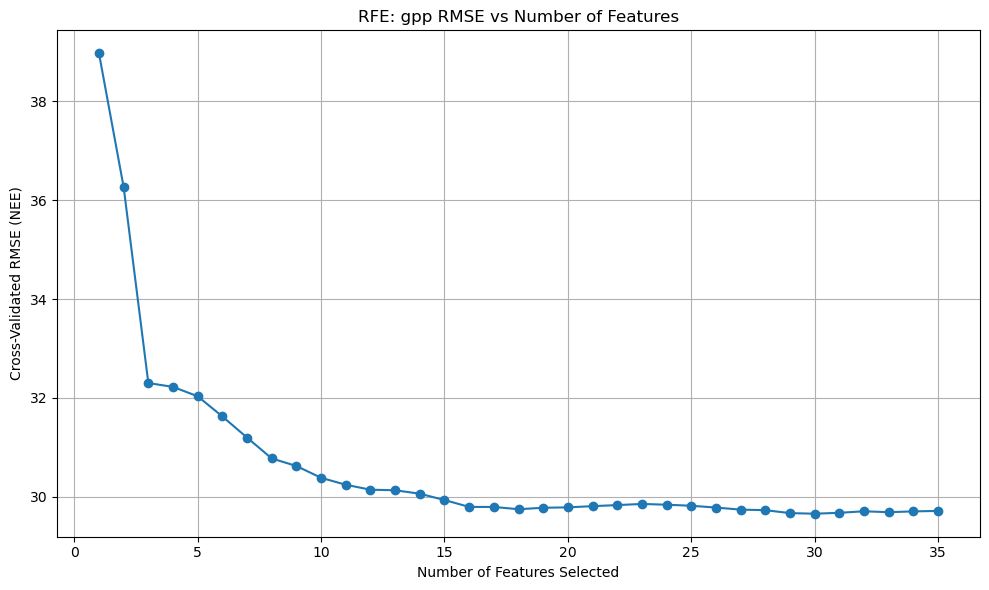

RFE curve plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/gpp/rfe.png

--- RFE Results ---
Optimal number of features found by RFE: 30
Features selected by RFE: ['EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs', 'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm', 'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm', 'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT', 'land_cover', 'month', 'lai', 'fpar', 'Percent_Tree_Cover', 'sm_surface', 'snow_depth']
-------------------

Training full model to determine top 6 predictors...
Model training complete.


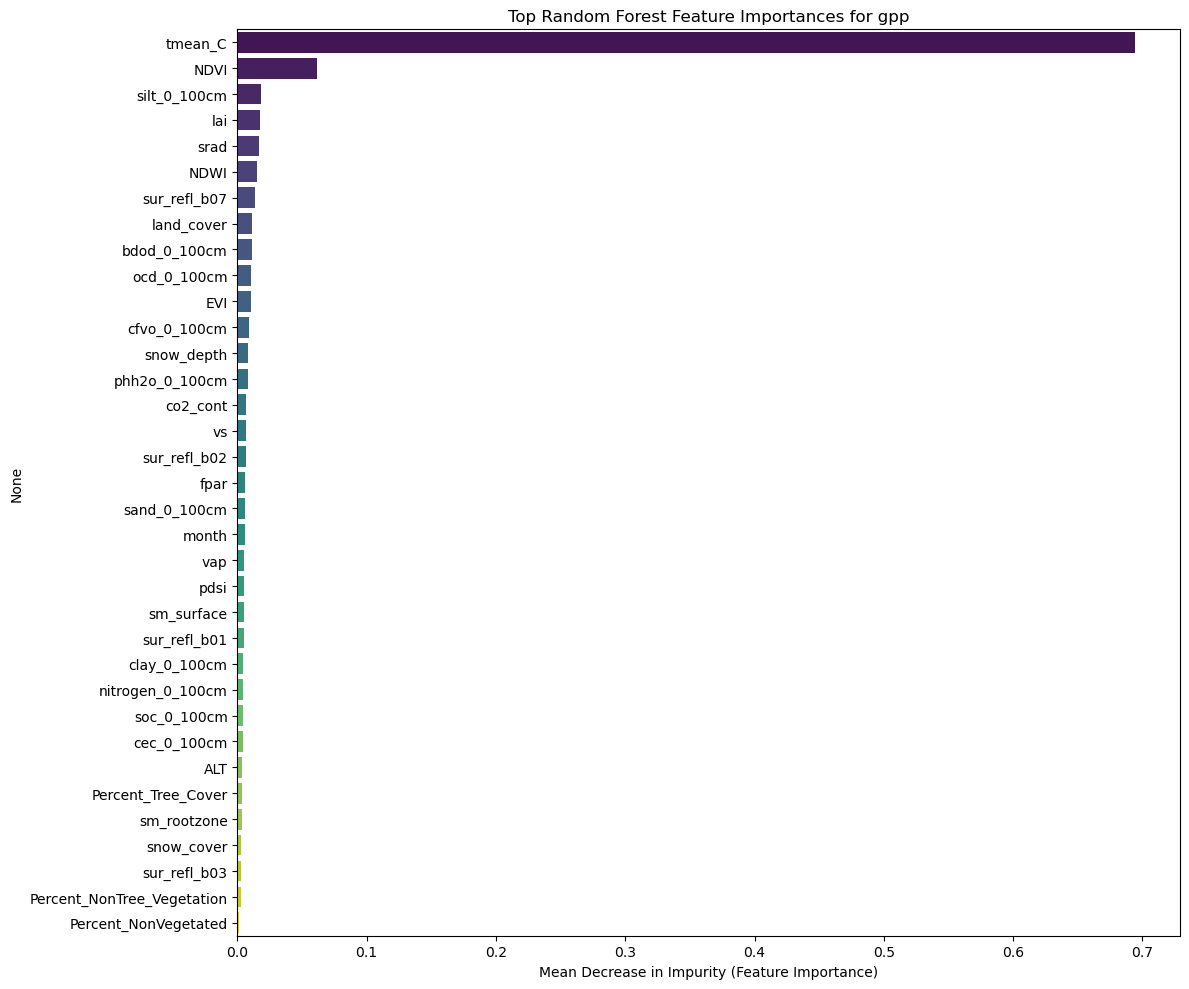

Feature importance plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/gpp/rf_importance.png

--- TopPredictor Selection ---
Top predictors selected: ['tmean_C', 'NDVI', 'silt_0_100cm', 'lai', 'srad', 'NDWI', 'sur_refl_b07', 'land_cover', 'bdod_0_100cm', 'ocd_0_100cm', 'EVI', 'cfvo_0_100cm', 'snow_depth', 'phh2o_0_100cm', 'co2_cont']
---------------------------------

New training dataframe with top 6 predictors saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/gpp/training_data_gpp_top_preds.csv
Shape of the new dataframe: (3131, 16)
Columns in the new dataframe: ['tmean_C', 'NDVI', 'silt_0_100cm', 'lai', 'srad', 'NDWI', 'sur_refl_b07', 'land_cover', 'bdod_0_100cm', 'ocd_0_100cm', 'EVI', 'cfvo_0_100cm', 'snow_depth', 'phh2o_0_100cm', 'co2_cont', 'gpp']


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, root_mean_squared_error
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Load your dataset
df = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv")
df = df[df['flux_method'] == 'EC']

# 2. Create tmean_C and date
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# 3. Define predictors and target
predictor_vars = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month', 
    'lai', 'fpar', 'Percent_NonTree_Vegetation',
    'Percent_NonVegetated', 'Percent_Tree_Cover',  'sm_surface', 'sm_rootzone',
    'snow_cover',
    'snow_depth'#, 'NDSI_snow_cover'
]

target_var = 'gpp'

out_path = os.path.join("/explore/nobackup/people/spotter5/anna_v/v2/loocv", target_var)
os.makedirs(out_path, exist_ok = True)

# 4. Drop rows with missing predictor or target values
df_model = df[predictor_vars + [target_var]].dropna()

# 5. Prepare input data
X = df_model[predictor_vars]
y = df_model[target_var]

# --- RFE Analysis Section ---
print("Running RFE analysis...")
# 6. Set up scoring, model, and cross-validation for RFE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rf_rfe = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7. Run RFECV
rfecv = RFECV(estimator=rf_rfe, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)
print("RFE analysis complete.")

# 8. Plot RMSE vs number of features from RFE
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    # Negate the score to plot positive RMSE values
    -rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (NEE)")
plt.title(f"RFE: {target_var} RMSE vs Number of Features")
plt.grid(True)
plt.tight_layout()
# --- Save plot with the original filename ---
rfe_plot_path = os.path.join(out_path, 'rfe.png')
plt.savefig(rfe_plot_path)
plt.show()
print(f"RFE curve plot saved to: {rfe_plot_path}")

# 9. Print features selected by RFE (for informational purposes)
rfe_selected_features = list(X.columns[rfecv.support_])
print("\n--- RFE Results ---")
print("Optimal number of features found by RFE:", rfecv.n_features_)
print("Features selected by RFE:", rfe_selected_features)
print("-------------------\n")


# --- Top 6 Predictor Selection Section ---
print("Training full model to determine top 6 predictors...")
# 10. Train a Random Forest on all features to get importance scores
full_rf = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
print("Model training complete.")

# 11. Get and sort feature importances
importances = pd.Series(full_rf.feature_importances_, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

# 12. Plot all feature importances for context
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title(f"Top Random Forest Feature Importances for {target_var}")
plt.tight_layout()
# --- Save plot with the original filename ---
importance_plot_path = os.path.join(out_path, 'rf_importance.png')
plt.savefig(importance_plot_path)
plt.show()
print(f"Feature importance plot saved to: {importance_plot_path}")

# 13. Select the top 6 predictors based on importance
top_6_predictors = sorted_importances.head(15).index.tolist()
print("\n--- TopPredictor Selection ---")
print("Top predictors selected:", top_6_predictors)
print("---------------------------------\n")

# 14. Create a new training dataframe with only the top 6 predictors and the target
df_training_top6 = df_model[top_6_predictors + [target_var]]

# 15. Save the new dataframe to a CSV file
output_csv_path = os.path.join(out_path, f'training_data_{target_var}_top_preds.csv')
df_training_top6.to_csv(output_csv_path, index=False)

print(f"New training dataframe with top 6 predictors saved to: {output_csv_path}")
print(f"Shape of the new dataframe: {df_training_top6.shape}")
print("Columns in the new dataframe:", df_training_top6.columns.tolist())

RFE RECO

Running RFE analysis...
RFE analysis complete.


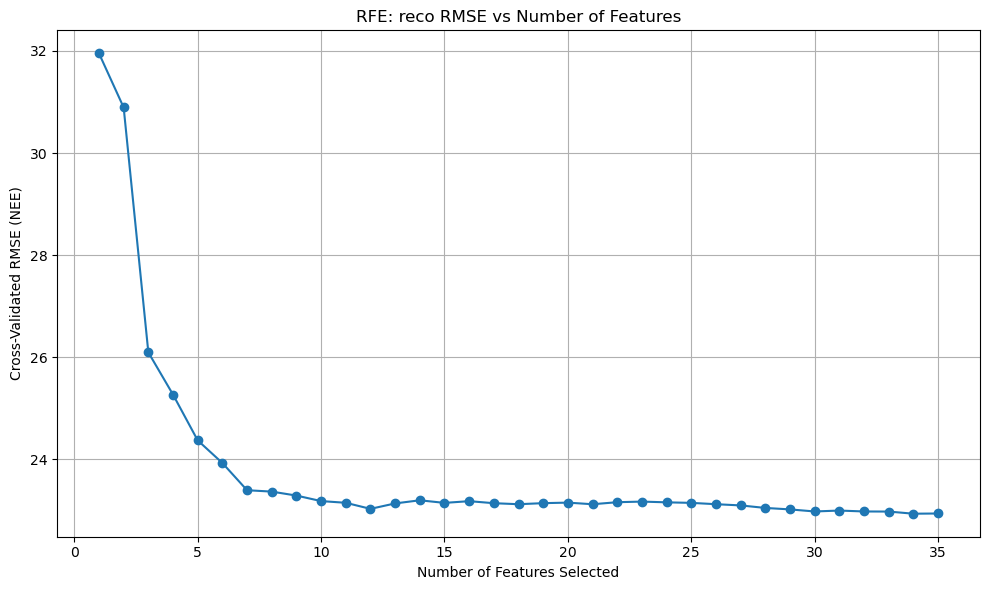

RFE curve plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/reco/rfe.png

--- RFE Results ---
Optimal number of features found by RFE: 34
Features selected by RFE: ['EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs', 'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm', 'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm', 'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT', 'land_cover', 'month', 'lai', 'fpar', 'Percent_NonTree_Vegetation', 'Percent_Tree_Cover', 'sm_surface', 'sm_rootzone', 'snow_cover', 'snow_depth']
-------------------

Training full model to determine top 6 predictors...
Model training complete.


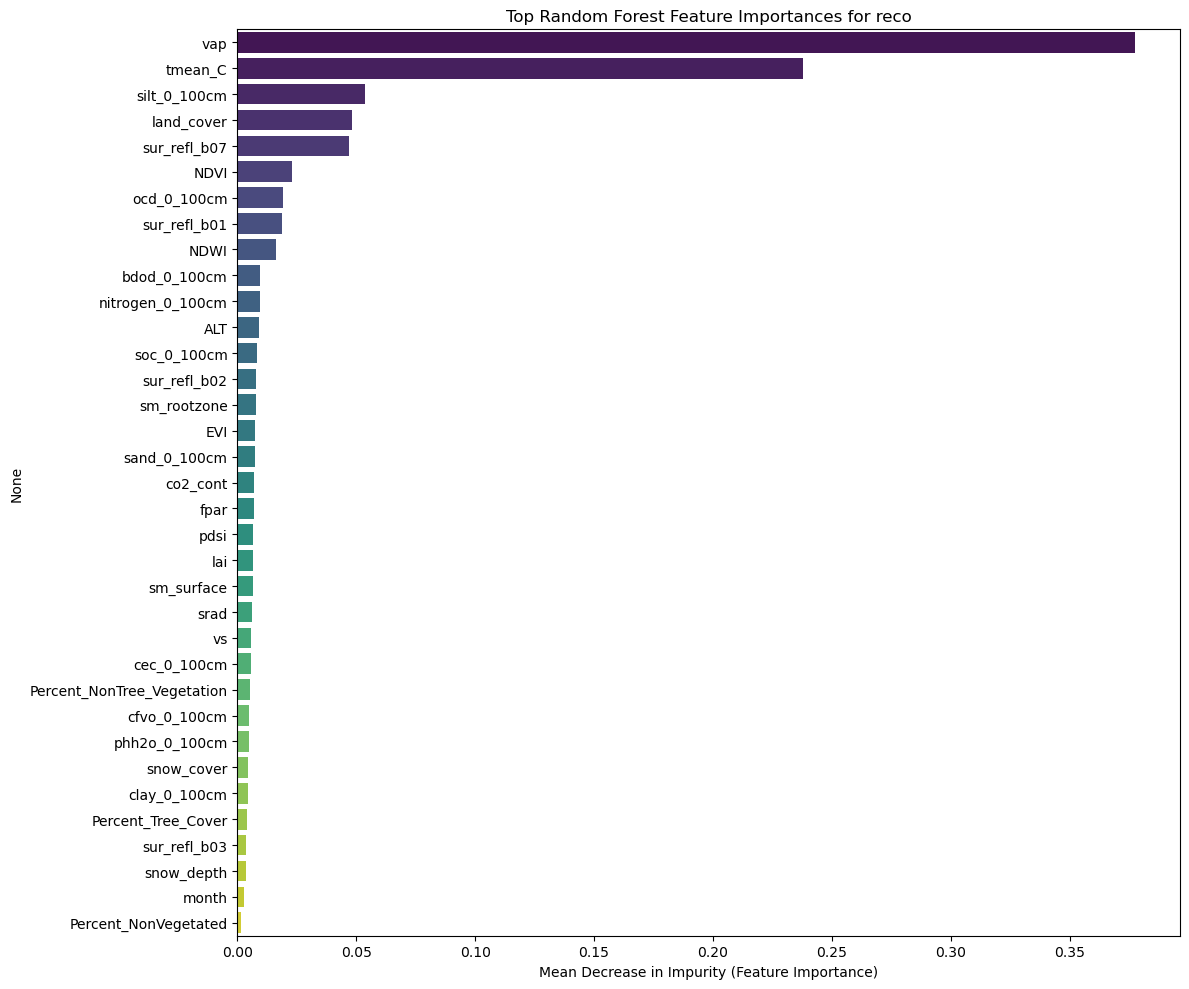

Feature importance plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/reco/rf_importance.png

--- TopPredictor Selection ---
Top predictors selected: ['vap', 'tmean_C', 'silt_0_100cm', 'land_cover', 'sur_refl_b07', 'NDVI', 'ocd_0_100cm', 'sur_refl_b01', 'NDWI', 'bdod_0_100cm']
---------------------------------

New training dataframe with top 6 predictors saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/reco/training_data_reco_top_preds.csv
Shape of the new dataframe: (3191, 11)
Columns in the new dataframe: ['vap', 'tmean_C', 'silt_0_100cm', 'land_cover', 'sur_refl_b07', 'NDVI', 'ocd_0_100cm', 'sur_refl_b01', 'NDWI', 'bdod_0_100cm', 'reco']


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, root_mean_squared_error
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Load your dataset
df = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv")
df = df[df['flux_method'] == 'EC']

# 2. Create tmean_C and date
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# 3. Define predictors and target
predictor_vars = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month', 
    'lai', 'fpar', 'Percent_NonTree_Vegetation',
    'Percent_NonVegetated', 'Percent_Tree_Cover',  'sm_surface', 'sm_rootzone',
    'snow_cover',
    'snow_depth'#, 'NDSI_snow_cover'
]

target_var = 'reco'

out_path = os.path.join("/explore/nobackup/people/spotter5/anna_v/v2/loocv", target_var)
os.makedirs(out_path, exist_ok = True)

# 4. Drop rows with missing predictor or target values
df_model = df[predictor_vars + [target_var]].dropna()

# 5. Prepare input data
X = df_model[predictor_vars]
y = df_model[target_var]

# --- RFE Analysis Section ---
print("Running RFE analysis...")
# 6. Set up scoring, model, and cross-validation for RFE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rf_rfe = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7. Run RFECV
rfecv = RFECV(estimator=rf_rfe, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)
print("RFE analysis complete.")

# 8. Plot RMSE vs number of features from RFE
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    # Negate the score to plot positive RMSE values
    -rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (NEE)")
plt.title(f"RFE: {target_var} RMSE vs Number of Features")
plt.grid(True)
plt.tight_layout()
# --- Save plot with the original filename ---
rfe_plot_path = os.path.join(out_path, 'rfe.png')
plt.savefig(rfe_plot_path)
plt.show()
print(f"RFE curve plot saved to: {rfe_plot_path}")

# 9. Print features selected by RFE (for informational purposes)
rfe_selected_features = list(X.columns[rfecv.support_])
print("\n--- RFE Results ---")
print("Optimal number of features found by RFE:", rfecv.n_features_)
print("Features selected by RFE:", rfe_selected_features)
print("-------------------\n")


# --- Top 6 Predictor Selection Section ---
print("Training full model to determine top 6 predictors...")
# 10. Train a Random Forest on all features to get importance scores
full_rf = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
print("Model training complete.")

# 11. Get and sort feature importances
importances = pd.Series(full_rf.feature_importances_, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

# 12. Plot all feature importances for context
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title(f"Top Random Forest Feature Importances for {target_var}")
plt.tight_layout()
# --- Save plot with the original filename ---
importance_plot_path = os.path.join(out_path, 'rf_importance.png')
plt.savefig(importance_plot_path)
plt.show()
print(f"Feature importance plot saved to: {importance_plot_path}")

# 13. Select the top 6 predictors based on importance
top_6_predictors = sorted_importances.head(10).index.tolist()
print("\n--- TopPredictor Selection ---")
print("Top predictors selected:", top_6_predictors)
print("---------------------------------\n")

# 14. Create a new training dataframe with only the top 6 predictors and the target
df_training_top6 = df_model[top_6_predictors + [target_var]]

# 15. Save the new dataframe to a CSV file
output_csv_path = os.path.join(out_path, f'training_data_{target_var}_top_preds.csv')
df_training_top6.to_csv(output_csv_path, index=False)

print(f"New training dataframe with top 6 predictors saved to: {output_csv_path}")
print(f"Shape of the new dataframe: {df_training_top6.shape}")
print("Columns in the new dataframe:", df_training_top6.columns.tolist())

RFE CH4

Running RFE analysis...
RFE analysis complete.


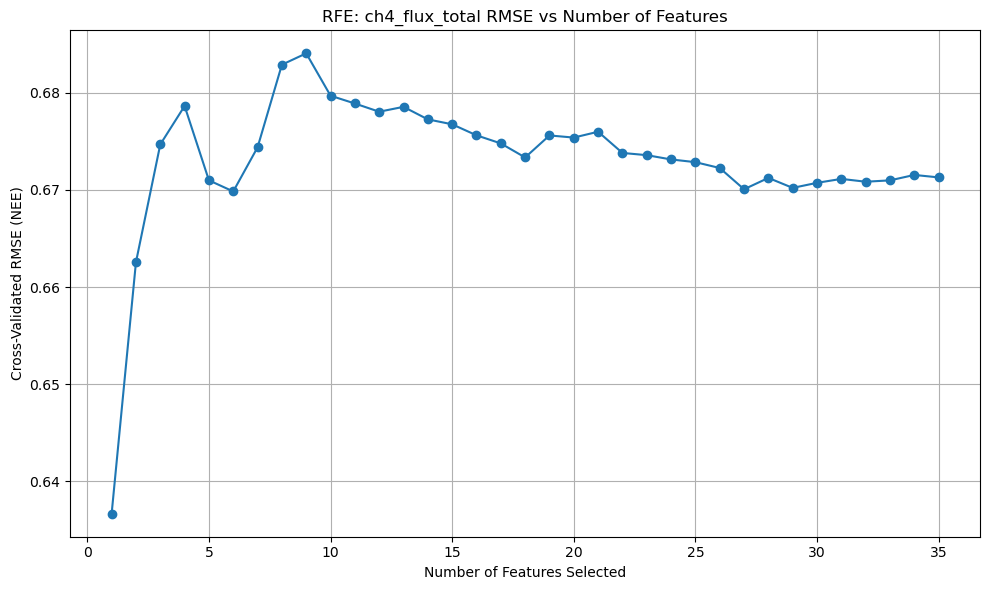

RFE curve plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/ch4_flux_total/rfe.png

--- RFE Results ---
Optimal number of features found by RFE: 1
Features selected by RFE: ['soc_0_100cm']
-------------------

Training full model to determine top 6 predictors...
Model training complete.


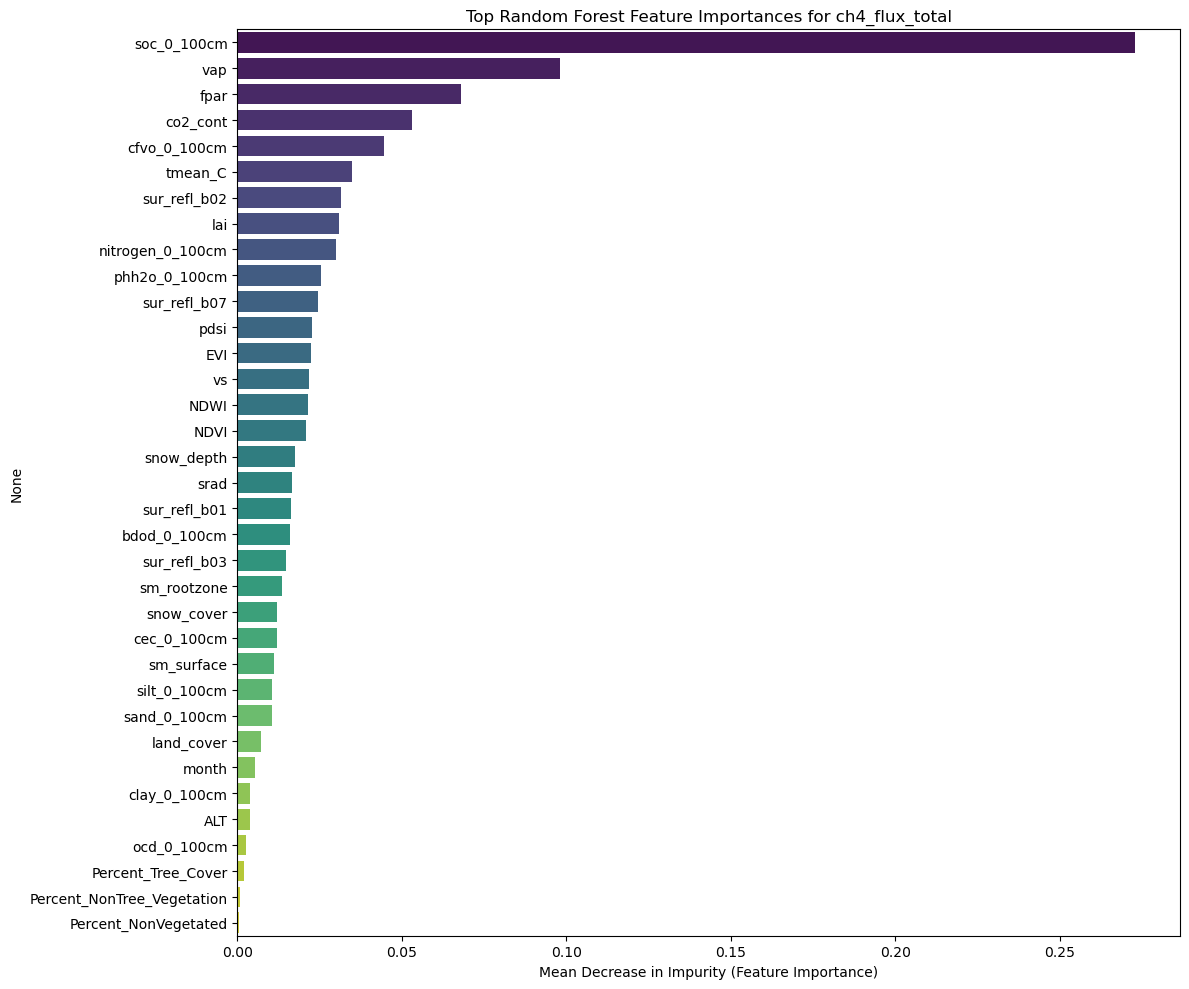

Feature importance plot saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/ch4_flux_total/rf_importance.png

--- TopPredictor Selection ---
Top predictors selected: ['soc_0_100cm', 'vap', 'fpar', 'co2_cont', 'cfvo_0_100cm', 'tmean_C', 'sur_refl_b02', 'lai', 'nitrogen_0_100cm', 'phh2o_0_100cm', 'sur_refl_b07', 'pdsi', 'EVI', 'vs', 'NDWI', 'NDVI', 'snow_depth', 'srad', 'sur_refl_b01', 'bdod_0_100cm', 'sur_refl_b03', 'sm_rootzone', 'snow_cover', 'cec_0_100cm', 'sm_surface']
---------------------------------

New training dataframe with top 6 predictors saved to: /explore/nobackup/people/spotter5/anna_v/v2/loocv/ch4_flux_total/training_data_ch4_flux_total_top_preds.csv
Shape of the new dataframe: (875, 26)
Columns in the new dataframe: ['soc_0_100cm', 'vap', 'fpar', 'co2_cont', 'cfvo_0_100cm', 'tmean_C', 'sur_refl_b02', 'lai', 'nitrogen_0_100cm', 'phh2o_0_100cm', 'sur_refl_b07', 'pdsi', 'EVI', 'vs', 'NDWI', 'NDVI', 'snow_depth', 'srad', 'sur_refl_b01', 'bdod_0_100cm', 'sur_refl_b0

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, root_mean_squared_error
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Load your dataset
df = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv")
df = df[df['flux_method'] == 'EC']

# 2. Create tmean_C and date
df['tmean_C'] = df[['tmmn', 'tmmx']].mean(axis=1)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# 3. Define predictors and target
predictor_vars = [
    'EVI', 'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
    'sur_refl_b07', 'NDWI', 'pdsi', 'srad', 'tmean_C', 'vap', 'vs',
    'bdod_0_100cm', 'cec_0_100cm', 'cfvo_0_100cm', 'clay_0_100cm',
    'nitrogen_0_100cm', 'ocd_0_100cm', 'phh2o_0_100cm', 'sand_0_100cm',
    'silt_0_100cm', 'soc_0_100cm', 'co2_cont', 'ALT',
    'land_cover', 'month', 
    'lai', 'fpar', 'Percent_NonTree_Vegetation',
    'Percent_NonVegetated', 'Percent_Tree_Cover',  'sm_surface', 'sm_rootzone',
    'snow_cover',
    'snow_depth'#, 'NDSI_snow_cover'
]

target_var = 'ch4_flux_total'

out_path = os.path.join("/explore/nobackup/people/spotter5/anna_v/v2/loocv", target_var)
os.makedirs(out_path, exist_ok = True)

# 4. Drop rows with missing predictor or target values
df_model = df[predictor_vars + [target_var]].dropna()

# 5. Prepare input data
X = df_model[predictor_vars]
y = df_model[target_var]

# --- RFE Analysis Section ---
print("Running RFE analysis...")
# 6. Set up scoring, model, and cross-validation for RFE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
rf_rfe = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7. Run RFECV
rfecv = RFECV(estimator=rf_rfe, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)
print("RFE analysis complete.")

# 8. Plot RMSE vs number of features from RFE
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    # Negate the score to plot positive RMSE values
    -rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (NEE)")
plt.title(f"RFE: {target_var} RMSE vs Number of Features")
plt.grid(True)
plt.tight_layout()
# --- Save plot with the original filename ---
rfe_plot_path = os.path.join(out_path, 'rfe.png')
plt.savefig(rfe_plot_path)
plt.show()
print(f"RFE curve plot saved to: {rfe_plot_path}")

# 9. Print features selected by RFE (for informational purposes)
rfe_selected_features = list(X.columns[rfecv.support_])
print("\n--- RFE Results ---")
print("Optimal number of features found by RFE:", rfecv.n_features_)
print("Features selected by RFE:", rfe_selected_features)
print("-------------------\n")


# --- Top 6 Predictor Selection Section ---
print("Training full model to determine top 6 predictors...")
# 10. Train a Random Forest on all features to get importance scores
full_rf = RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
print("Model training complete.")

# 11. Get and sort feature importances
importances = pd.Series(full_rf.feature_importances_, index=X.columns)
sorted_importances = importances.sort_values(ascending=False)

# 12. Plot all feature importances for context
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title(f"Top Random Forest Feature Importances for {target_var}")
plt.tight_layout()
# --- Save plot with the original filename ---
importance_plot_path = os.path.join(out_path, 'rf_importance.png')
plt.savefig(importance_plot_path)
plt.show()
print(f"Feature importance plot saved to: {importance_plot_path}")

# 13. Select the top 6 predictors based on importance
top_6_predictors = sorted_importances.head(25).index.tolist()
print("\n--- TopPredictor Selection ---")
print("Top predictors selected:", top_6_predictors)
print("---------------------------------\n")

# 14. Create a new training dataframe with only the top 6 predictors and the target
df_training_top6 = df_model[top_6_predictors + [target_var]]

# 15. Save the new dataframe to a CSV file
output_csv_path = os.path.join(out_path, f'training_data_{target_var}_top_preds.csv')
df_training_top6.to_csv(output_csv_path, index=False)

print(f"New training dataframe with top 6 predictors saved to: {output_csv_path}")
print(f"Shape of the new dataframe: {df_training_top6.shape}")
print("Columns in the new dataframe:", df_training_top6.columns.tolist())

In [16]:
't'

't'